In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
!pip install mplcyberpunk


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

2024-05-18 11:10:40.088527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 11:10:40.088580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 11:10:40.090028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import pandas as pd
from PIL import Image

# Define the path to your dataset
dataset_path = '/kaggle/input/brain-tumor-classification-mri/Training'

# Initialize lists to hold file paths and labels
image_paths = []
labels = []

# Load the data from directories
for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(label)

# Create a DataFrame
data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Display the first few rows of the dataset
print(data.head())

# Basic statistics
print(data['label'].value_counts())

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")


                                          image_path     label
0  /kaggle/input/brain-tumor-classification-mri/T...  no_tumor
1  /kaggle/input/brain-tumor-classification-mri/T...  no_tumor
2  /kaggle/input/brain-tumor-classification-mri/T...  no_tumor
3  /kaggle/input/brain-tumor-classification-mri/T...  no_tumor
4  /kaggle/input/brain-tumor-classification-mri/T...  no_tumor
label
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64
Training set size: 2296
Testing set size: 574


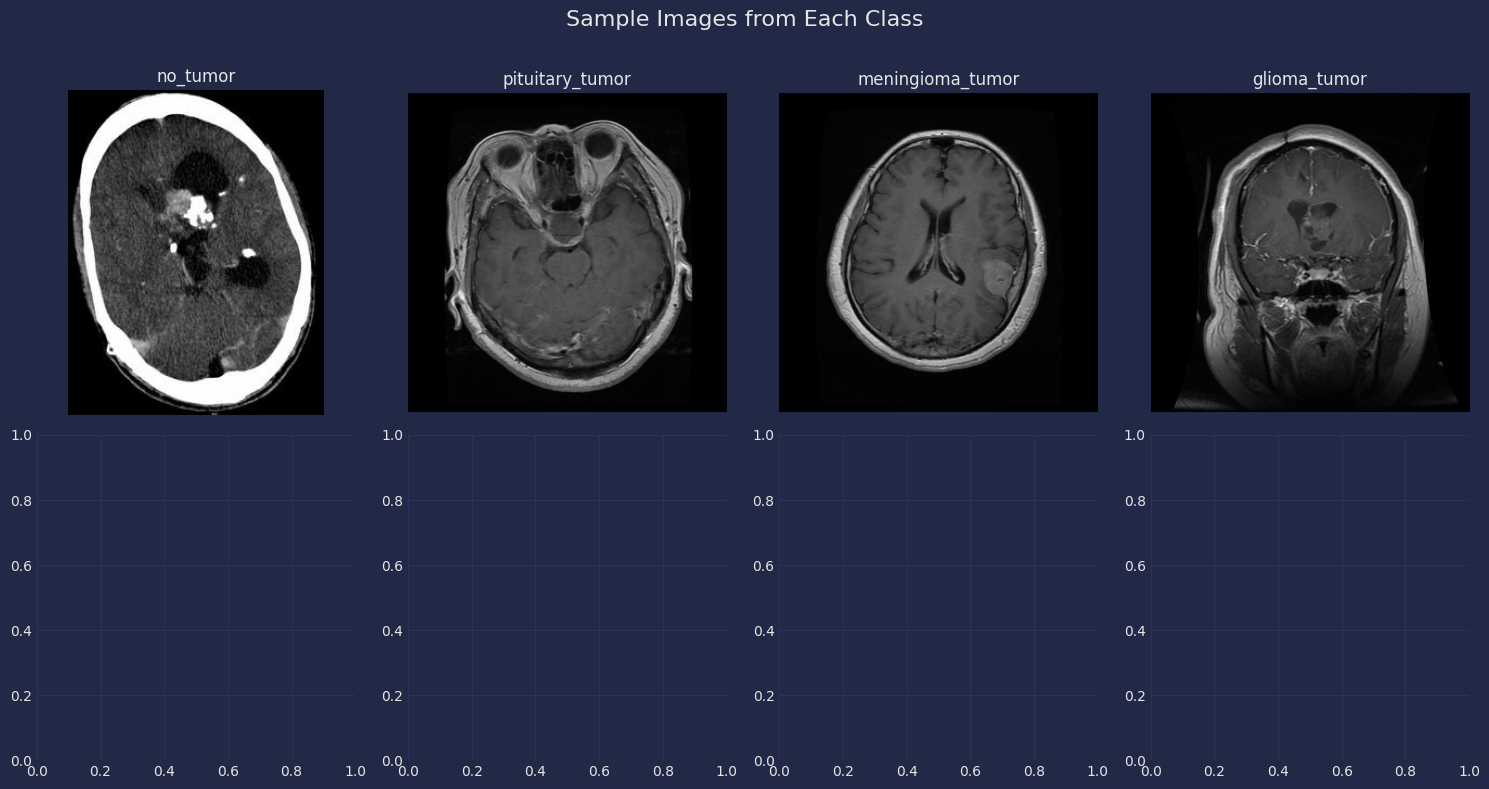

In [5]:
def plot_sample_images(data, rows=2, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    fig.suptitle('Sample Images from Each Class', fontsize=16)
    
    class_labels = data['label'].unique()
    for i, label in enumerate(class_labels):
        sample = data[data['label'] == label].sample(1).iloc[0]
        img = Image.open(sample['image_path'])
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

plot_sample_images(data)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Figure size 1200x600 with 0 Axes>

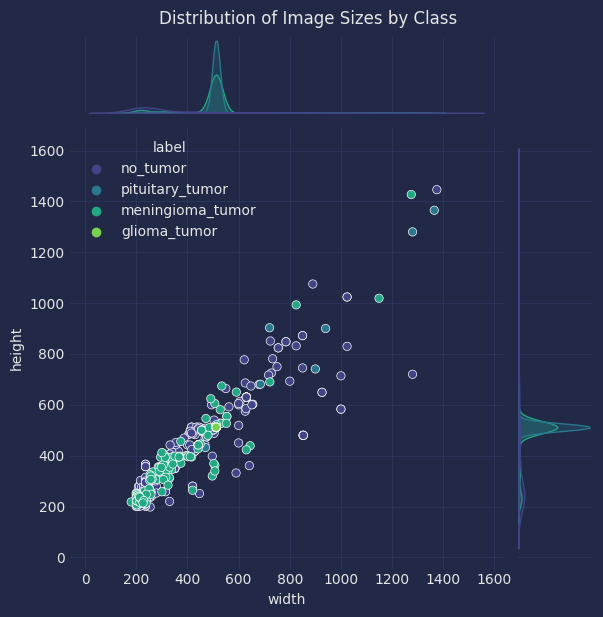

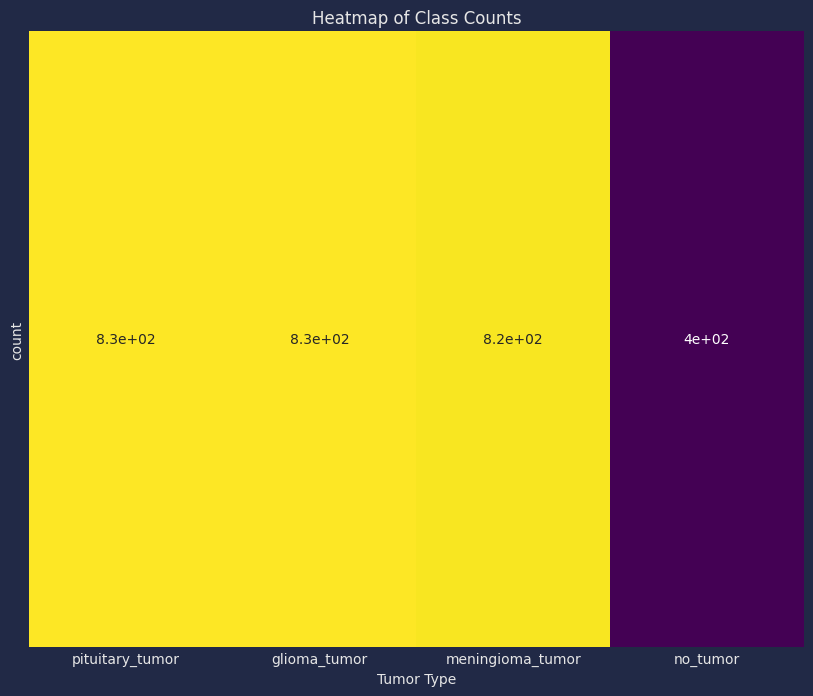

In [6]:
# Distribution of image sizes
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

data['image_size'] = data['image_path'].apply(get_image_size)
data['width'] = data['image_size'].apply(lambda x: x[0])
data['height'] = data['image_size'].apply(lambda x: x[1])

plt.figure(figsize=(12, 6))
sns.jointplot(data=data, x='width', y='height', hue='label', palette='viridis')
plt.suptitle('Distribution of Image Sizes by Class', y=1.02)
plt.show()

# Heatmap of class correlation
plt.figure(figsize=(10, 8))
class_counts = data['label'].value_counts()
class_df = pd.DataFrame(class_counts).transpose()
sns.heatmap(class_df, annot=True, cmap='viridis', cbar=False)
plt.title('Heatmap of Class Counts')
plt.xlabel('Tumor Type')
plt.show()


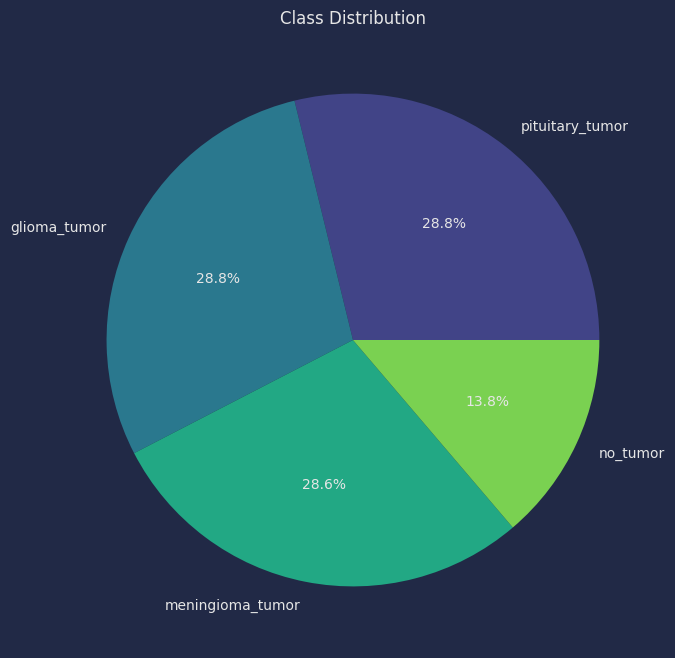

In [7]:
# Pie Chart for class distribution
plt.figure(figsize=(8, 8))
data['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', n_colors=len(data['label'].unique())))
plt.title('Class Distribution')
plt.ylabel('')
plt.show()


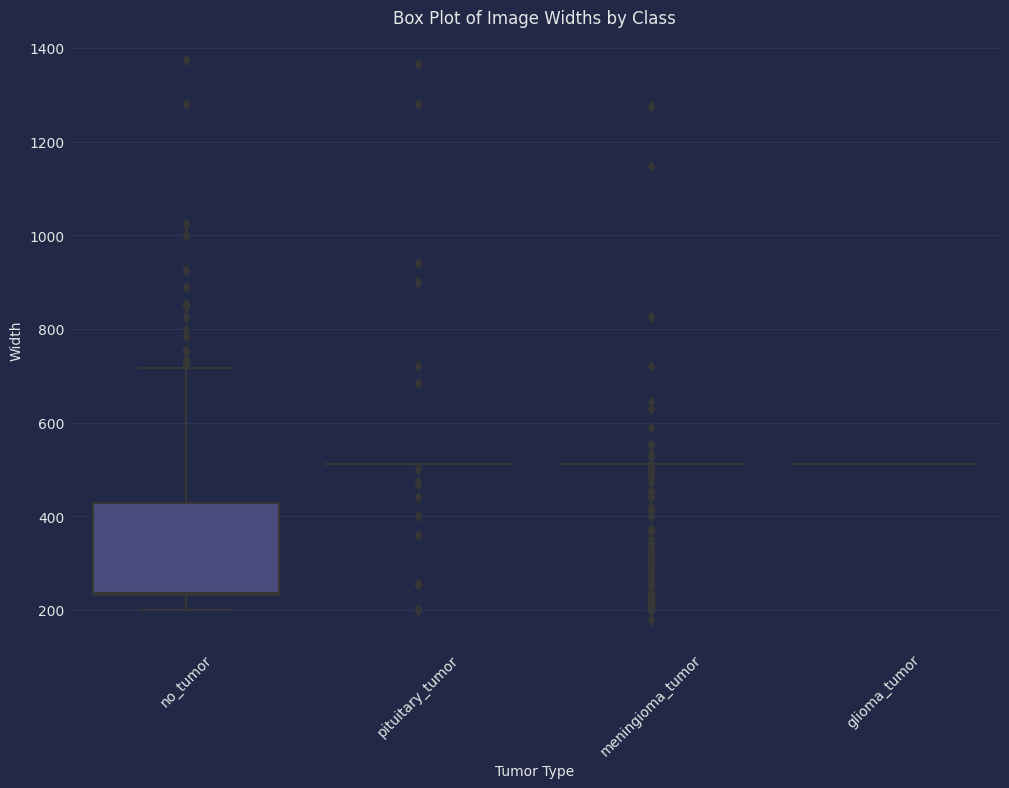

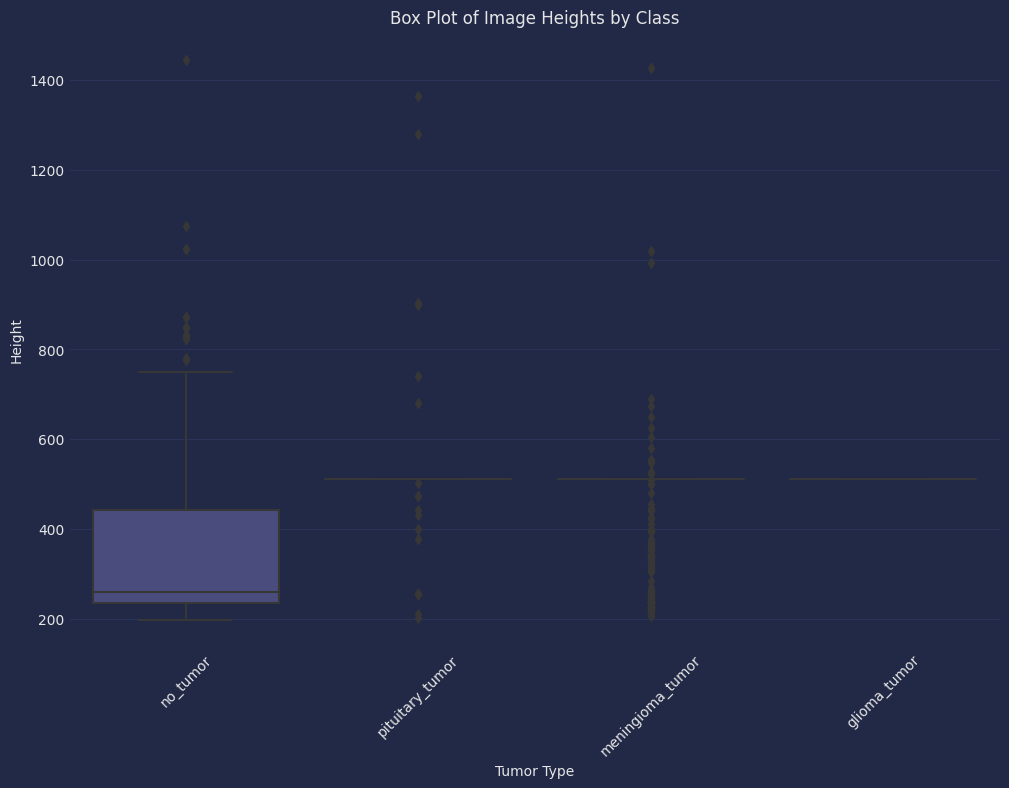

In [8]:
# Box Plot of Image Sizes by Class
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='label', y='width', palette='viridis')
plt.title('Box Plot of Image Widths by Class')
plt.xlabel('Tumor Type')
plt.ylabel('Width')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='label', y='height', palette='viridis')
plt.title('Box Plot of Image Heights by Class')
plt.xlabel('Tumor Type')
plt.ylabel('Height')
plt.xticks(rotation=45)
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

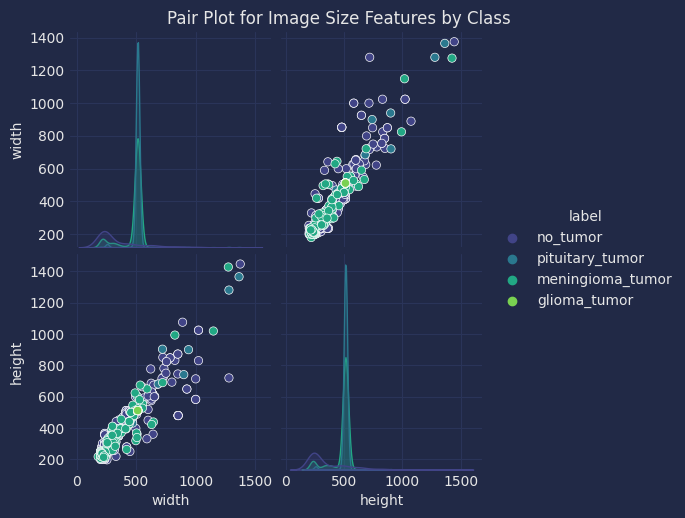

In [9]:
# Pair Plot for Image Size Features by Class
sns.pairplot(data, hue='label', palette='viridis', height=2.5)
plt.suptitle('Pair Plot for Image Size Features by Class', y=1.02)
plt.show()


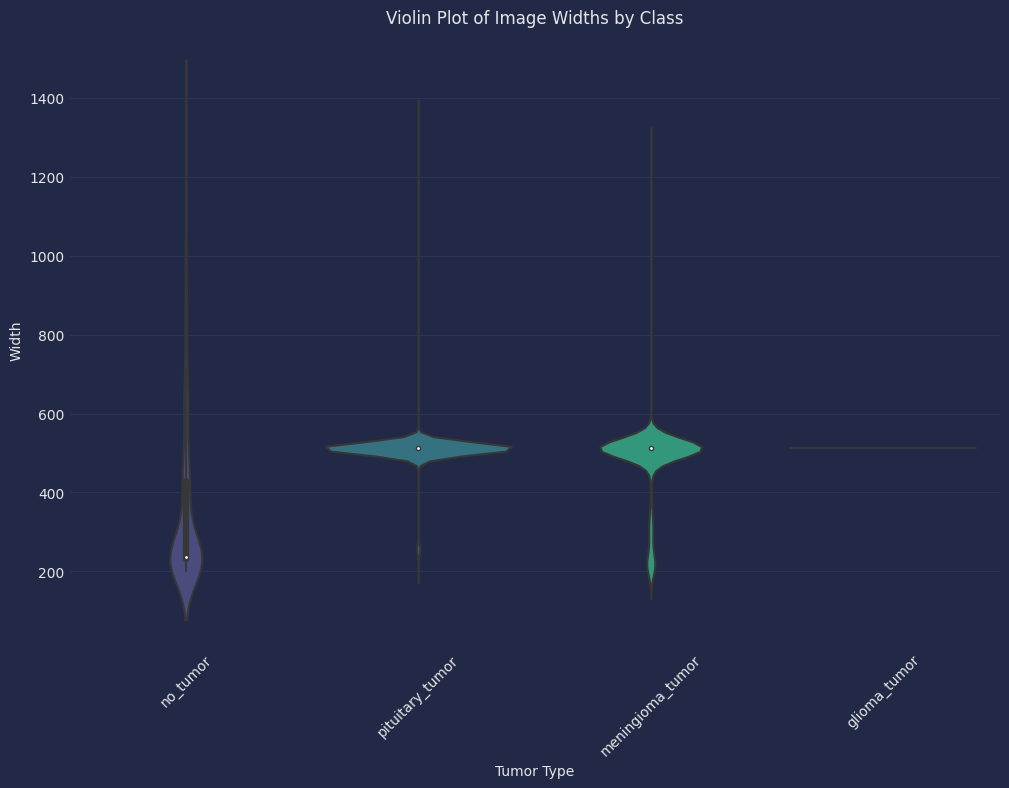

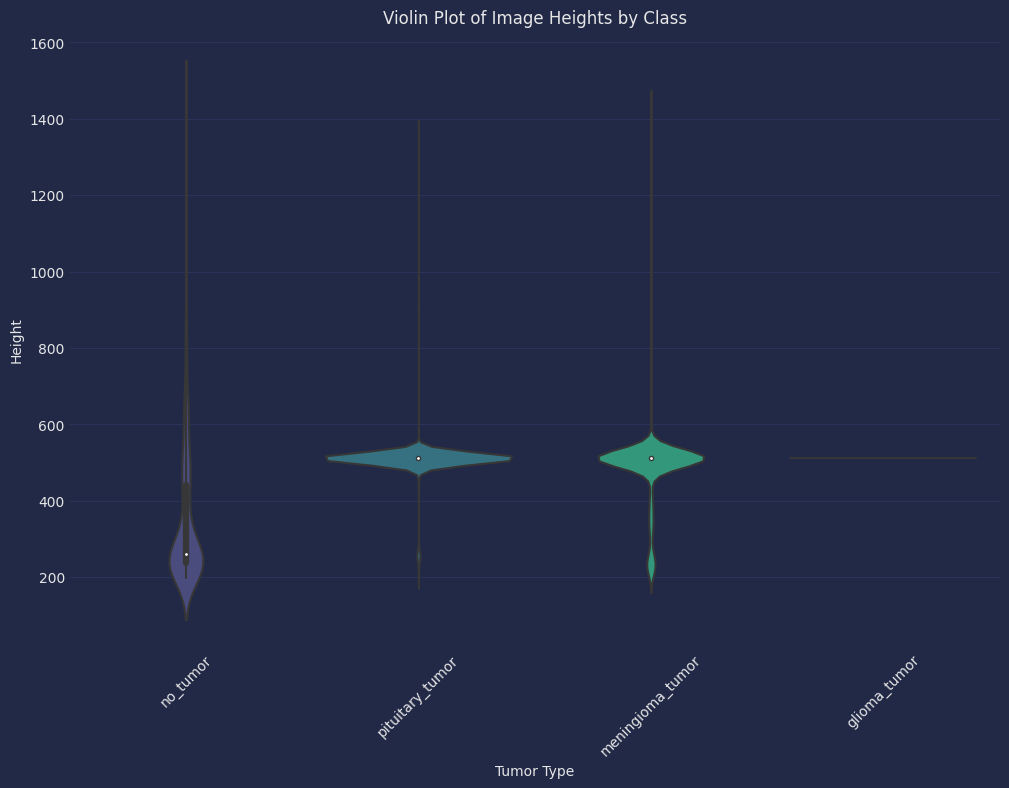

In [10]:
# Violin Plot for Image Size Distribution by Class
plt.figure(figsize=(12, 8))
sns.violinplot(data=data, x='label', y='width', palette='viridis')
plt.title('Violin Plot of Image Widths by Class')
plt.xlabel('Tumor Type')
plt.ylabel('Width')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.violinplot(data=data, x='label', y='height', palette='viridis')
plt.title('Violin Plot of Image Heights by Class')
plt.xlabel('Tumor Type')
plt.ylabel('Height')
plt.xticks(rotation=45)
plt.show()


In [11]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-classification-mri/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 136.89it/s]


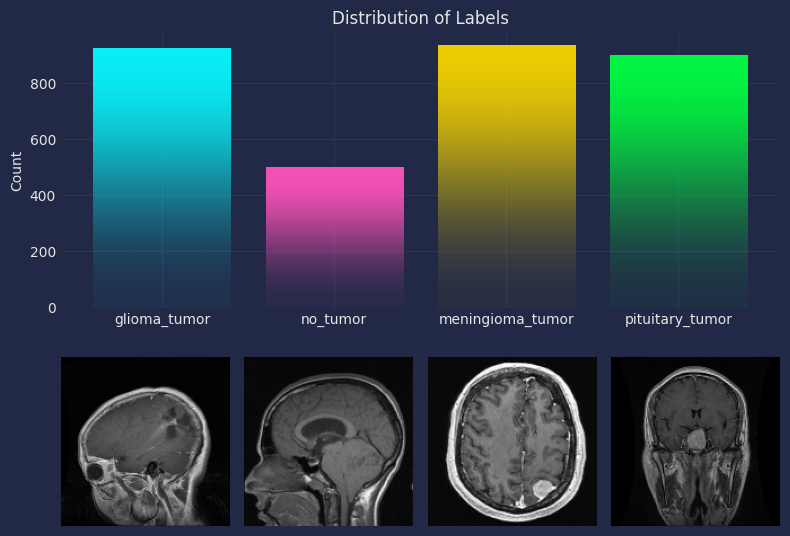

In [12]:
# Calculate the bar plot for each label
import mplcyberpunk
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Define image size and batch size
image_size = (150, 150)
batch_size = 32

# Load and preprocess images
def load_images(df, image_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Load images
X_train, y_train = load_images(train_data, image_size)
X_test, y_test = load_images(test_data, image_size)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (2296, 150, 150, 3)
Testing data shape: (574, 150, 150, 3)


In [14]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Define the model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(len(lb.classes_), activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Define data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Train the model
# history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
#                     validation_data=(X_test, y_test),
#                     epochs=20)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {accuracy * 100:.2f}%")


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0 ,Xception
from tensorflow.keras.optimizers import Adam

# Load the Xception model, without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

#

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1536,activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=20)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 1:53:32 96s/step - accuracy: 0.1562 - loss: 1.4856

I0000 00:00:1716030778.180509    7320 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716030778.284481    7320 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/72 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - accuracy: 0.5162 - loss: 1.1020

W0000 00:00:1716030840.260987    7318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.6737 - loss: 0.8142

W0000 00:00:1716030853.966311    7317 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6752 - loss: 0.8113 - val_accuracy: 0.1359 - val_loss: 3.7276
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9070 - loss: 0.3031 - val_accuracy: 0.1359 - val_loss: 4.6186
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9042 - loss: 0.2686 - val_accuracy: 0.1359 - val_loss: 1.8201
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9336 - loss: 0.1854 - val_accuracy: 0.1359 - val_loss: 4.3103
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9365 - loss: 0.1860 - val_accuracy: 0.3240 - val_loss: 2.0874
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.9291 - loss: 0.1917 - val_accuracy: 0.1359 - val_loss: 6.9590
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9406 - loss: 0.1762 - val_accuracy: 0.1359 - val_loss: 6.2168
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9413 - loss: 0.1712 - val_accuracy: 0.1359 

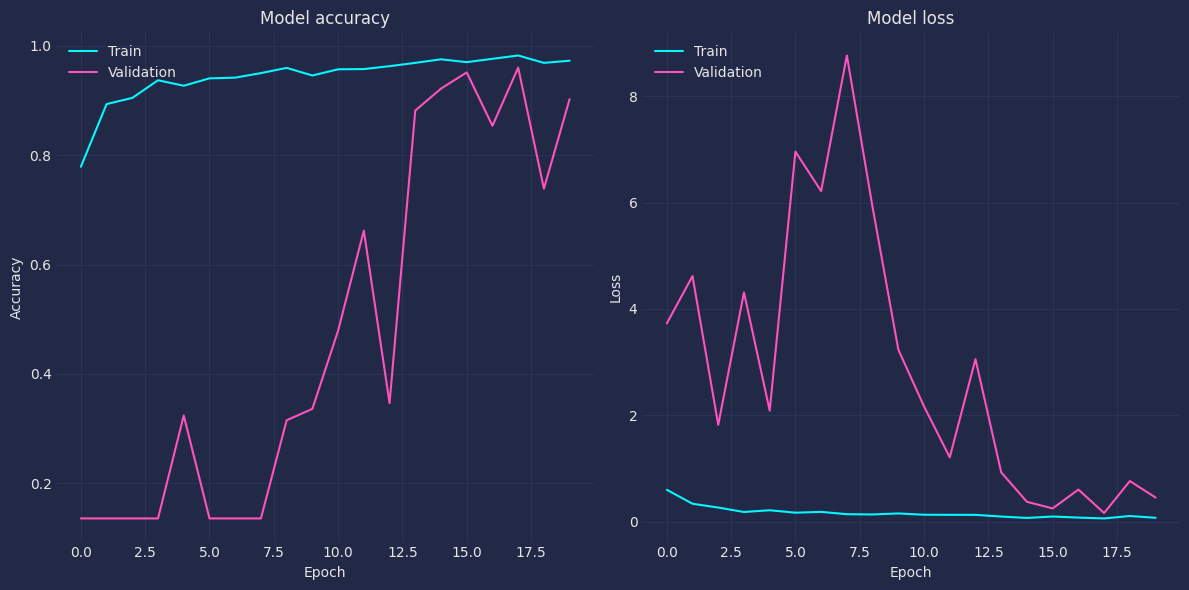

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import classification_report

# Predict the labels of the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_)
print(report)


10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

W0000 00:00:1716031096.237191    7319 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.99      0.91       155
meningioma_tumor       0.97      0.73      0.83       161
        no_tumor       0.90      0.95      0.92        78
 pituitary_tumor       0.93      0.96      0.94       180

        accuracy                           0.90       574
       macro avg       0.91      0.91      0.90       574
    weighted avg       0.91      0.90      0.90       574

